## Executive Summary

This notebook implements a bottom-up, auditable model with a causal flow:

- Adoption: industry deployment uses a supply-constrained exponential ramp (ceiling model) starting in 2025.
- Schedule: design/EPC/commissioning with rework and uplift; experiments reduce design time and late surprises.
- Deployment: cumulative reactors and annual additions (base vs FM) without mid-horizon slowdowns.
- Operations learning: capacity factor and effective power output rise gradually over decades; O&M costs fall.
- Economics: CAPEX via two-factor learning with floor; LCOE uses dynamic net power and O&M trajectories.

We show base vs FM for each stage and print key metrics at 2030/2040/2050.


In [1]:
# Setup & Imports
# Paths and configuration
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import yaml
try:
    import mplcursors
    HOVER = True
except Exception:
    HOVER = False

# High-DPI inline output for sharper figures
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip:
        ip.run_line_magic('config', "InlineBackend.figure_format = 'retina'")
except Exception:
    pass

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 180
plt.rcParams['savefig.dpi'] = 240
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

sns.set_context("talk", font_scale=1.15)

from fmvalue.models import Config
from fmvalue.fm_levers import map_fm_to_knobs
from fmvalue.adoption import (
    constrained_logistic_with_ceiling_ramp,
    exponential_additions_with_ceiling,
)
from fmvalue.schedule import draw_schedule_months
from fmvalue.experiments import time_to_gate_days, fm_adjust_experiment_inputs
from fmvalue.ops_learning import ops_learning_factors, power_output_multiplier
from fmvalue.learning_curve import capex_two_factor
from fmvalue.finance import lcoe_series
from fmvalue.viz import ribbons

sns.set_context("talk"); sns.set_style("whitegrid")

# Load YAML inputs
with open('inputs.yaml', 'r') as f:
    INPUTS = yaml.safe_load(f)

cfg = Config(**INPUTS)
base = cfg.base_config



c:\Users\Alex\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Alex\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
c:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Adoption (Base vs FM)
We model deployment using a supply-driven ceiling model starting in 2025. The annual build capability ramps up exponentially and is capped by a maximum ceiling; cumulative reactors are the integral of annual additions. FM pulls the adoption inflection earlier via schedule acceleration and marginally steepens adoption via sharing (k multiplier).


2030: additions base/FM = 0.87/0.97 per year; cumulative base/FM = 4.0/4.3
2040: additions base/FM = 2.60/3.62 per year; cumulative base/FM = 20.7/25.7
2050: additions base/FM = 7.82/13.56 per year; cumulative base/FM = 70.8/106.1


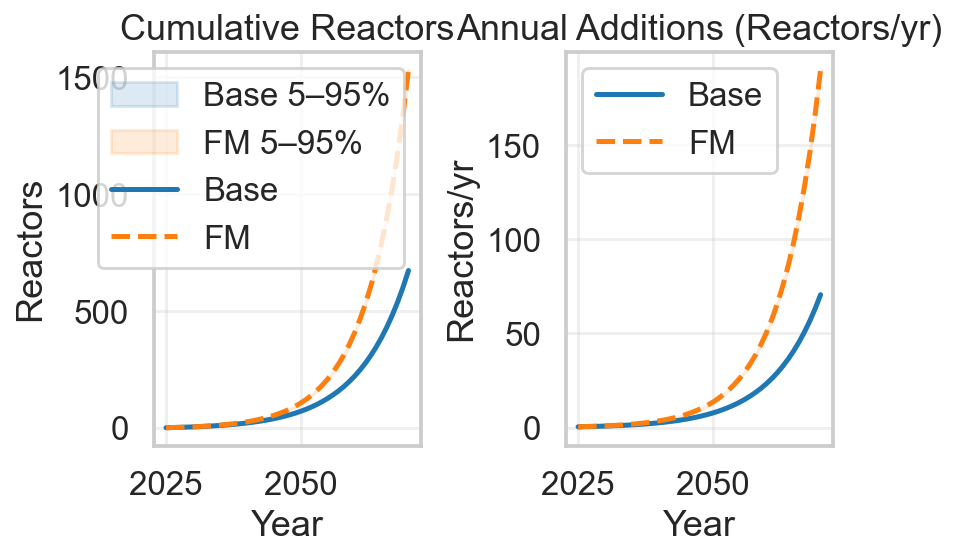

In [2]:
# Adoption calculation
A = base.adoption
L = base.learning
O = base.ops
F = base.finance
years = np.arange(2025, 2071)

# Base: exponential additions capped by ceiling (align with config + MC)
dN_cap_base = np.minimum(
    A.ceiling_start_per_year * np.exp(A.ceiling_growth * (years - years[0])),
    A.max_build_rate_per_year
)
N_base = np.cumsum(dN_cap_base)

# FM knobs
knobs = map_fm_to_knobs(base, base, with_fm=True)
# FM: steeper adoption via sharing multiplier on growth (align with MC)
fm_growth = A.ceiling_growth * knobs["k_mult"]
dN_cap_fm = np.minimum(
    A.ceiling_start_per_year * np.exp(fm_growth * (years - years[0])),
    A.max_build_rate_per_year
)
N_fm = np.cumsum(dN_cap_fm)

from fmvalue.mc import run_once

n_trials = 300
rows_b, rows_f = [], []
for i in range(n_trials):
    out_b = run_once(cfg, rng_seed=1000 + i, with_fm=False)
    out_f = run_once(cfg, rng_seed=2000 + i, with_fm=True)
    for y, nb in zip(out_b["years"], out_b["N"]):
        rows_b.append({"year": int(y), "N": float(nb)})
    for y, nf in zip(out_f["years"], out_f["N"]):
        rows_f.append({"year": int(y), "N": float(nf)})
import pandas as pd
rb = ribbons(pd.DataFrame(rows_b), key="N")
rf = ribbons(pd.DataFrame(rows_f), key="N")

fig, ax = plt.subplots(1,2)
# Left: cumulative reactors with ribbons
# Adjust ribbons to match plotted central paths
rb_med = rb["q50"].to_numpy(); rf_med = rf["q50"].to_numpy()
rb_low = (rb_med - rb["q5"].to_numpy()); rb_high = (rb["q95"].to_numpy() - rb_med)
rf_low = (rf_med - rf["q5"].to_numpy()); rf_high = (rf["q95"].to_numpy() - rf_med)
rb_c_low = N_base - rb_low; rb_c_high = N_base + rb_high
rf_c_low = N_fm   - rf_low; rf_c_high = N_fm   + rf_high
ax[0].fill_between(rb["year"], rb_c_low, rb_c_high, color="#1f77b4", alpha=0.15, label="Base 5–95%")
ax[0].fill_between(rf["year"], rf_c_low, rf_c_high, color="#ff7f0e", alpha=0.15, label="FM 5–95%")
line_nb_b, = ax[0].plot(years, N_base, label="Base", linewidth=2.5, color="#1f77b4")
line_nb_f, = ax[0].plot(years, N_fm, label="FM", linestyle="--", linewidth=2.5, color="#ff7f0e")
ax[0].set_title("Cumulative Reactors")
ax[0].set_ylabel("Reactors")
ax[0].set_xlabel("Year")
ax[0].legend(frameon=True, loc='best'); ax[0].grid(True, alpha=0.3)

# Right: annual additions with ribbons
# Derive additions from quantiles approximately by diff of quantile series
add_rb = rb.copy(); add_rb["adds_q5"] = add_rb["q5"].diff().clip(lower=0).fillna(0)
add_rb["adds_q95"] = add_rb["q95"].diff().clip(lower=0).fillna(0)
add_rf = rf.copy(); add_rf["adds_q5"] = add_rf["q5"].diff().clip(lower=0).fillna(0)
add_rf["adds_q95"] = add_rf["q95"].diff().clip(lower=0).fillna(0)
ax[1].fill_between(add_rb["year"], add_rb["adds_q5"], add_rb["adds_q95"], color="#1f77b4", alpha=0.15)
ax[1].fill_between(add_rf["year"], add_rf["adds_q5"], add_rf["adds_q95"], color="#ff7f0e", alpha=0.15)
line_add_b, = ax[1].plot(years, dN_cap_base, label="Base", linewidth=2.5, color="#1f77b4")
line_add_f, = ax[1].plot(years, dN_cap_fm, label="FM", linestyle="--", linewidth=2.5, color="#ff7f0e")
ax[1].set_title("Annual Additions (Reactors/yr)")
ax[1].set_ylabel("Reactors/yr")
ax[1].set_xlabel("Year")
ax[1].legend(frameon=True, loc='best'); ax[1].grid(True, alpha=0.3)

# Hover tooltips if available
if 'HOVER' in globals() and HOVER:
    for l in [line_nb_b, line_nb_f, line_add_b, line_add_f]:
        mplcursors.cursor(l, hover=True)

# Key point readouts
for y in [2030, 2040, 2050]:
    i = int(np.clip(y - years[0], 0, len(years)-1))
    print(f"{y}: additions base/FM = {dN_cap_base[i]:.2f}/{dN_cap_fm[i]:.2f} per year; cumulative base/FM = {N_base[i]:.1f}/{N_fm[i]:.1f}")

plt.tight_layout()
plt.show()


### Schedule, Experiments â†’ Schedule Acceleration
We draw schedule durations (design/EPC/commissioning) with rework and reference-class uplift. Experiments reduce time-to-gate, which lowers design time and rework probability, shifting FM deployment left (earlier COD â†’ earlier adoption inflection). We summarize deterministic base vs FM schedule months for context.


In [3]:
# Deterministic schedule sketch
rng = np.random.default_rng(7)
months_base = draw_schedule_months(base.schedule, None, rng)
# FM experiments â†’ adjust inputs
s_pg, p_s = fm_adjust_experiment_inputs(base.experiments, base.fm_effects.experiments)
months_fm = draw_schedule_months(base.schedule, base.fm_effects.simulation, rng)
print(f"Schedule (months) base/FM: {months_base:.1f} / {months_fm:.1f} (Î”={months_base-months_fm:.1f})")


Schedule (months) base/FM: 119.3 / 96.1 (Î”=23.2)


### Operations: Capacity Factor, Power Output, and O&M (Base vs FM)
We apply long-horizon operations learning curves that:
- gradually increase CF and effective net power output,
- gradually reduce O&M (FOM/VOM),
with FM accelerating these curves. This allows LCOE to continue falling even after CAPEX reaches its floor.


2030: CF=52.7/58.5%, NetMW=1049/1061, FOM=98.2/94.0 M$/yr
2040: CF=76.0/83.5%, NetMW=1154/1193, FOM=94.7/83.7 M$/yr
2050: CF=76.5/84.9%, NetMW=1269/1342, FOM=91.5/75.2 M$/yr


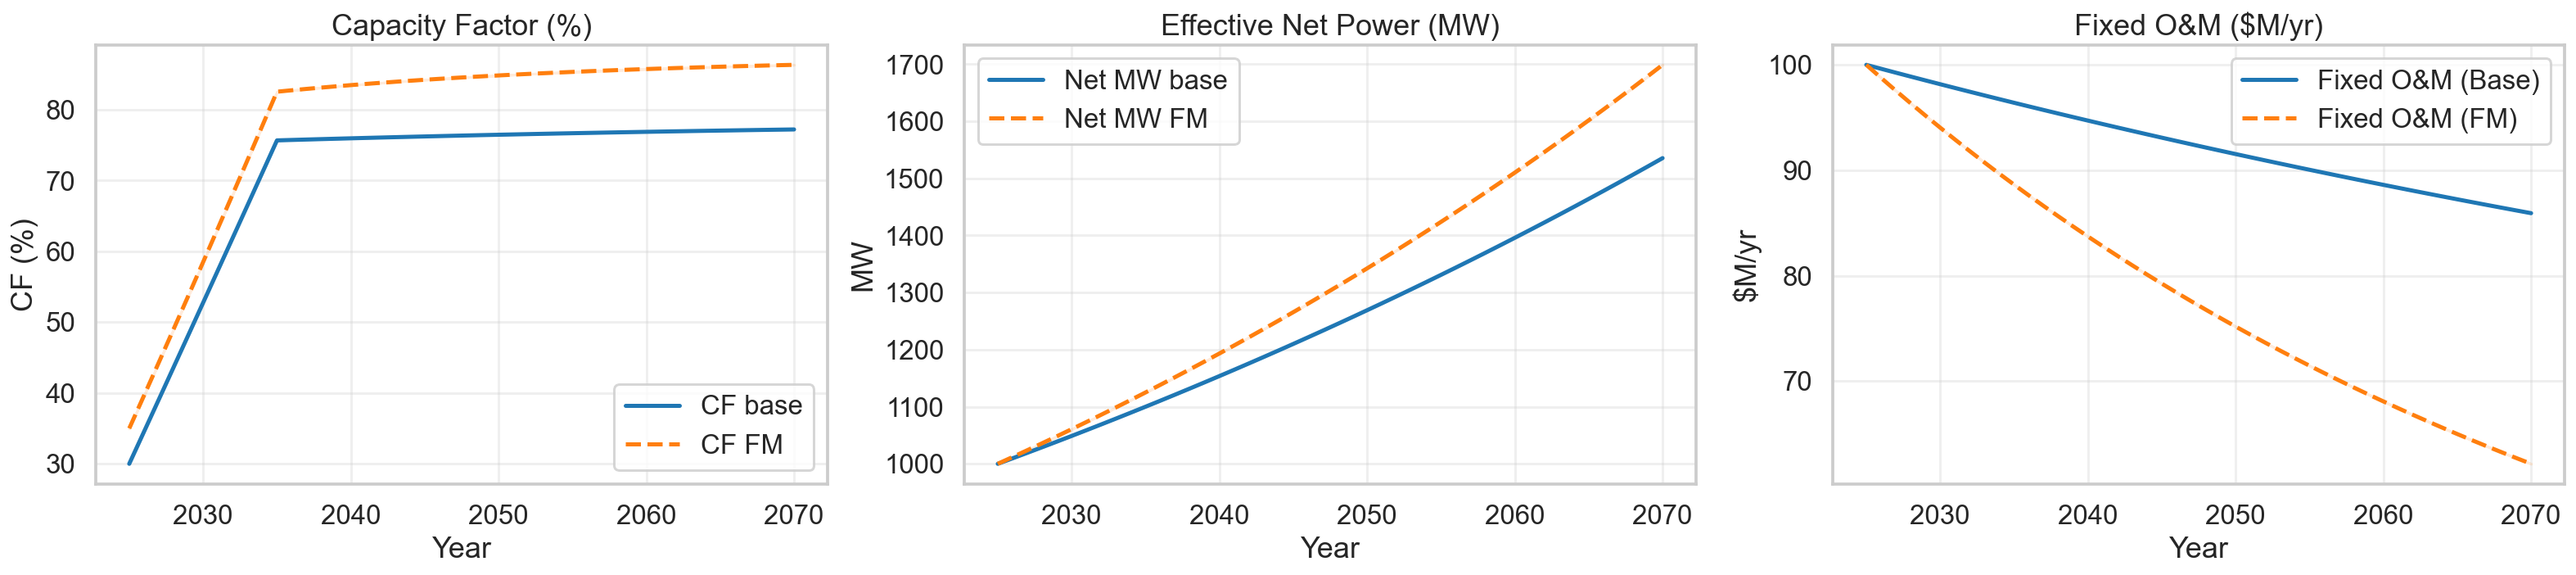

In [ ]:
# Ops learning trajectories - MUCH slower to avoid steep CF curve
cf_ramp = np.clip(np.interp(years, [years[0], years[0] + base.ops.commissioning_ramp_years], [base.ops.cf_base_initial, base.ops.cf_base_mature], right=base.ops.cf_base_mature), 0.01, 0.95)

# Very gradual saturation: long time constants (50yr base, 30yr FM) for smooth CF growth
cf_learn_b, om_learn_b = ops_learning_factors(years, base.learning.t0, 
    tau_cf=50.0, tau_om=120.0, cf_fm_boost=0.0, om_fm_boost=0.0, 
    max_cf_gain=0.05, max_om_reduction=0.45)
cf_learn_f, om_learn_f = ops_learning_factors(years, base.learning.t0, 
    tau_cf=30.0, tau_om=80.0, cf_fm_boost=0.2, om_fm_boost=0.22, 
    max_cf_gain=0.1, max_om_reduction=0.65)

cf_base_series = np.clip(cf_ramp * cf_learn_b, 0.01, 0.95)
cf_fm_series   = np.clip(cf_ramp * cf_learn_f + base.fm_effects.control.cf_uplift_abs, 0.01, 0.95)
# Keep CF learning as-is; apply separate power-output learning (~10% per decade base, +25% boost FM)
# Power-output learning settings
power_mult_b = power_output_multiplier(years, base.learning.t0, per_decade=0.10, fm_boost=0.0, cap=2.0)
power_mult_f = power_output_multiplier(years, base.learning.t0, per_decade=0.10, fm_boost=0.2, cap=2.0)
net_power_base = base.meta.power_net_MW * power_mult_b
net_power_fm   = base.meta.power_net_MW * power_mult_f
fom_base_series = base.ops.fom_base_per_year * om_learn_b
# Apply FM control reduction only to the learned portion so both start equal
fom_fm_series   = base.ops.fom_base_per_year * om_learn_f * (1.0 - base.fm_effects.control.fom_reduction_pct * (1.0 - om_learn_f))
vom_base_series = base.ops.vom_base_per_MWh * om_learn_b
# Apply FM control reduction only to the learned portion so both start equal
vom_fm_series   = base.ops.vom_base_per_MWh * om_learn_f * (1.0 - base.fm_effects.control.vom_reduction_pct * (1.0 - om_learn_f))

# Uncertainty bands for operations (CF, power, FOM)
from fmvalue.mc import run_once
n_trials_ops = 300
rows_cf_b, rows_cf_f = [], []
rows_np_b, rows_np_f = [], []
rows_fom_b, rows_fom_f = [], []
for i in range(n_trials_ops):
    ob = run_once(cfg, rng_seed=3100 + i, with_fm=False)
    of = run_once(cfg, rng_seed=4100 + i, with_fm=True)
    # Recompute ops series consistent with deterministic series length if needed
    for y, cfv in zip(ob["years"], np.clip(cf_ramp * cf_learn_b, 0.01, 0.95)):
        rows_cf_b.append({"year": int(y), "cf": float(cfv)})
    for y, cfv in zip(of["years"], np.clip(cf_ramp * cf_learn_f + base.fm_effects.control.cf_uplift_abs, 0.01, 0.95)):
        rows_cf_f.append({"year": int(y), "cf": float(cfv)})
    for y, mv in zip(ob["years"], net_power_base):
        rows_np_b.append({"year": int(y), "mw": float(mv)})
    for y, mv in zip(of["years"], net_power_fm):
        rows_np_f.append({"year": int(y), "mw": float(mv)})
    for y, fv in zip(ob["years"], fom_base_series/1e6):
        rows_fom_b.append({"year": int(y), "fom": float(fv)})
    for y, fv in zip(of["years"], fom_fm_series/1e6):
        rows_fom_f.append({"year": int(y), "fom": float(fv)})
import pandas as pd
rcf_b = ribbons(pd.DataFrame(rows_cf_b), key="cf")
rcf_f = ribbons(pd.DataFrame(rows_cf_f), key="cf")
rnp_b = ribbons(pd.DataFrame(rows_np_b), key="mw")
rnp_f = ribbons(pd.DataFrame(rows_np_f), key="mw")
rfm_b = ribbons(pd.DataFrame(rows_fom_b), key="fom")
rfm_f = ribbons(pd.DataFrame(rows_fom_f), key="fom")

fig, ax = plt.subplots(1,3)
fig.set_size_inches(22, 5)

# Adjust CF bands to match plotted central paths
cfb_med = rcf_b["q50"].to_numpy()*100; cf_fm_med = rcf_f["q50"].to_numpy()*100
cfb_low = (cfb_med - rcf_b["q5"].to_numpy()*100); cfb_high = (rcf_b["q95"].to_numpy()*100 - cfb_med)
cf_fm_low = (cf_fm_med - rcf_f["q5"].to_numpy()*100); cf_fm_high = (rcf_f["q95"].to_numpy()*100 - cf_fm_med)
ax[0].fill_between(rcf_b["year"], cf_base_series*100 - cfb_low, cf_base_series*100 + cfb_high, color="#1f77b4", alpha=0.15)
ax[0].fill_between(rcf_f["year"], cf_fm_series*100 - cf_fm_low, cf_fm_series*100 + cf_fm_high, color="#ff7f0e", alpha=0.15)
line_cf_b, = ax[0].plot(years, cf_base_series*100, label="CF base", linewidth=2.5)
line_cf_f, = ax[0].plot(years, cf_fm_series*100, label="CF FM", linestyle="--", linewidth=2.5)
ax[0].set_title("Capacity Factor (%)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("CF (%)")
ax[0].legend(frameon=True, loc='best'); ax[0].grid(True, alpha=0.3)

# Adjust power bands to match plotted central paths
npb_med = rnp_b["q50"].to_numpy(); npf_med = rnp_f["q50"].to_numpy()
npb_low = (npb_med - rnp_b["q5"].to_numpy()); npb_high = (rnp_b["q95"].to_numpy() - npb_med)
npf_low = (npf_med - rnp_f["q5"].to_numpy()); npf_high = (rnp_f["q95"].to_numpy() - npf_med)
ax[1].fill_between(rnp_b["year"], net_power_base - npb_low, net_power_base + npb_high, color="#1f77b4", alpha=0.15)
ax[1].fill_between(rnp_f["year"], net_power_fm - npf_low, net_power_fm + npf_high, color="#ff7f0e", alpha=0.15)
line_np_b, = ax[1].plot(years, net_power_base, label="Net MW base", linewidth=2.5)
line_np_f, = ax[1].plot(years, net_power_fm, label="Net MW FM", linestyle="--", linewidth=2.5)
ax[1].set_title("Effective Net Power (MW)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("MW")
ax[1].legend(frameon=True, loc='best'); ax[1].grid(True, alpha=0.3)

# Adjust FOM bands to match plotted central paths
fomb_med = rfm_b["q50"].to_numpy(); fomf_med = rfm_f["q50"].to_numpy()
fomb_low = (fomb_med - rfm_b["q5"].to_numpy()); fomb_high = (rfm_b["q95"].to_numpy() - fomb_med)
fomf_low = (fomf_med - rfm_f["q5"].to_numpy()); fomf_high = (rfm_f["q95"].to_numpy() - fomf_med)
ax[2].fill_between(rfm_b["year"], (fom_base_series/1e6) - fomb_low, (fom_base_series/1e6) + fomb_high, color="#1f77b4", alpha=0.15)
ax[2].fill_between(rfm_f["year"], (fom_fm_series/1e6) - fomf_low, (fom_fm_series/1e6) + fomf_high, color="#ff7f0e", alpha=0.15)
line_fom_b, = ax[2].plot(years, fom_base_series/1e6, label="Fixed O&M (Base)", linewidth=2.5)
line_fom_f, = ax[2].plot(years, fom_fm_series/1e6, label="Fixed O&M (FM)", linestyle="--", linewidth=2.5)
ax[2].set_title("Fixed O&M ($M/yr)")
ax[2].set_xlabel("Year")
ax[2].set_ylabel("$M/yr")
ax[2].legend(frameon=True, loc='best'); ax[2].grid(True, alpha=0.3)

# Hover tooltips if available
if 'HOVER' in globals() and HOVER:
    for l in [line_cf_b, line_cf_f, line_np_b, line_np_f, line_fom_b, line_fom_f]:
        mplcursors.cursor(l, hover=True)

# Key readouts for 2030/2040/2050
for y in [2030, 2040, 2050]:
    i = int(np.clip(y - years[0], 0, len(years)-1))
    print(f"{y}: CF={cf_base_series[i]*100:.1f}/{cf_fm_series[i]*100:.1f}%, NetMW={net_power_base[i]:.0f}/{net_power_fm[i]:.0f}, FOM={fom_base_series[i]/1e6:.1f}/{fom_fm_series[i]/1e6:.1f} M$/yr")

plt.tight_layout()
plt.show()


### CAPEX and LCOE (Base vs FM)
We combine deployment (N), CAPEX learning (two-factor with floor), and operations learning to compute LCOE over time. We also print key values at 2030, 2040, 2050.


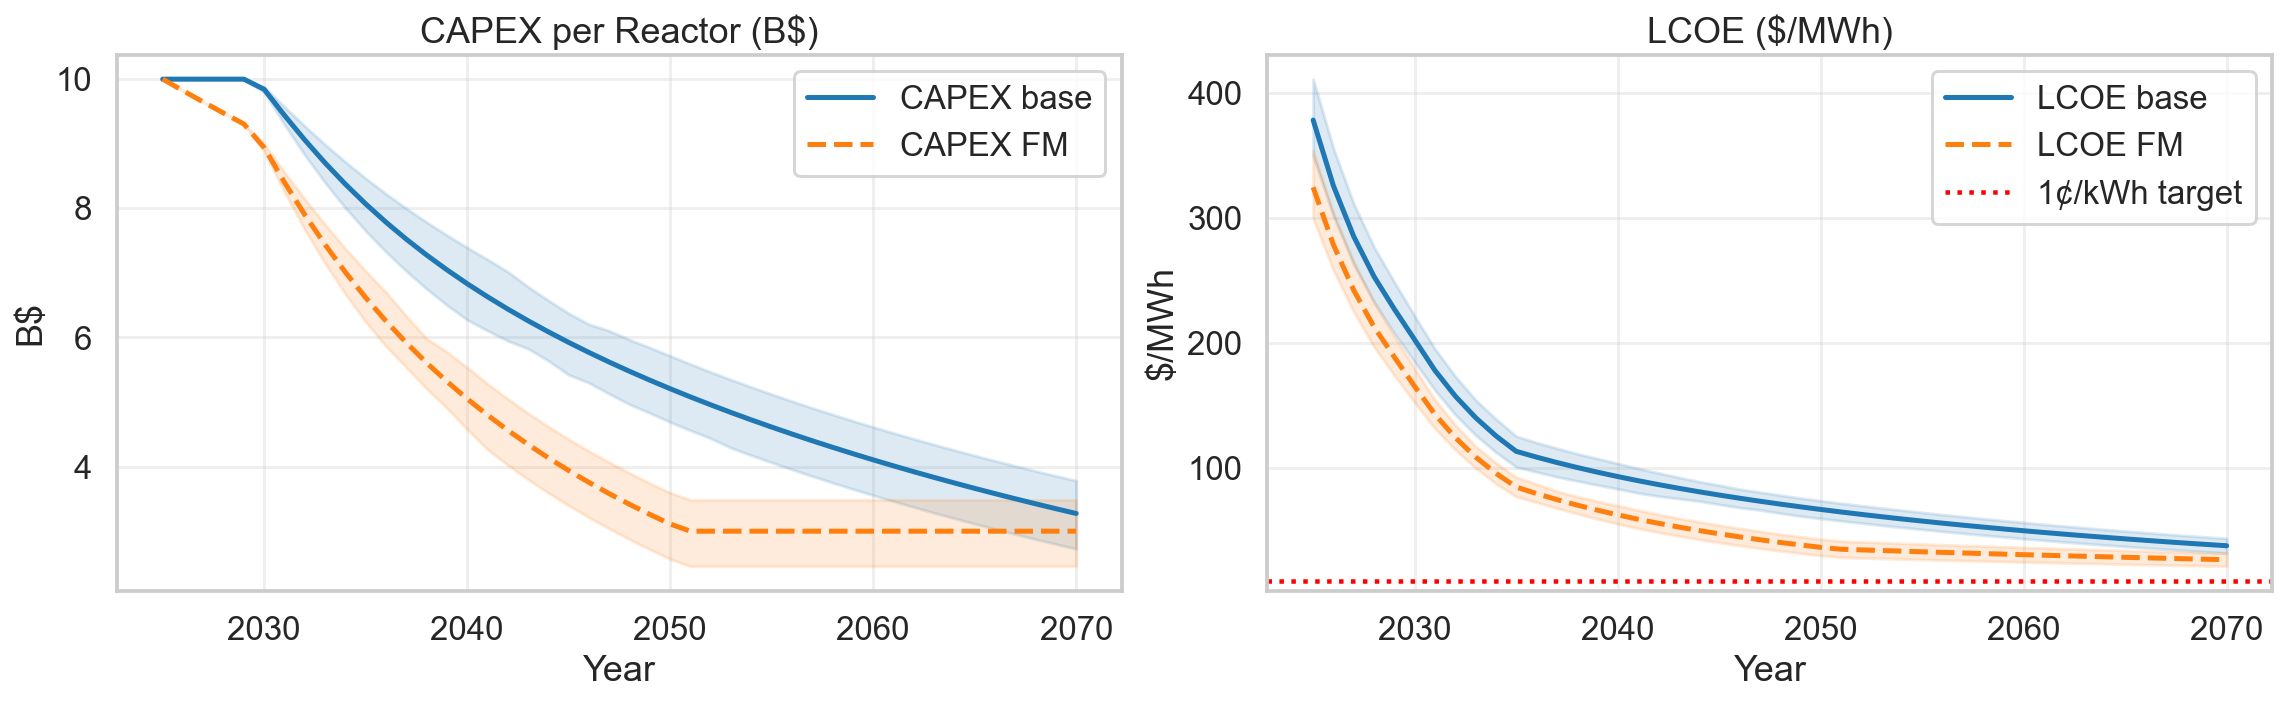

2030: N=4.0/4.3, CAPEX=9.84/8.94 B$, LCOE=202.6/165.3 $/MWh
2040: N=20.7/25.7, CAPEX=6.83/5.05 B$, LCOE=93.3/62.7 $/MWh
2050: N=70.8/106.1, CAPEX=5.21/3.11 B$, LCOE=67.0/36.7 $/MWh


In [5]:
# CAPEX and LCOE computation
capex_base = capex_two_factor(N_base, years, base.learning.capex0_FOAK_USD, base.learning.capex_floor_USD,
                              base.learning.b_exponent, base.learning.g_exogenous_per_year,
                              base.learning.N0, base.learning.t0, getattr(base.learning, 'inertia_years', 0.0))
capex_fm = capex_two_factor(N_fm, years, base.learning.capex0_FOAK_USD, base.learning.capex_floor_USD,
                            base.learning.b_exponent + base.fm_effects.sharing.delta_b_exponent,
                            base.learning.g_exogenous_per_year + base.fm_effects.simulation.delta_g_per_year,
                            base.learning.N0, base.learning.t0, getattr(base.learning, 'inertia_years', 0.0))

lcoe_base = lcoe_series(capex_base, cf_base_series, fom_base_series, vom_base_series, base.finance.wacc_real, base.finance.life_years, net_power_base)
lcoe_fm   = lcoe_series(capex_fm,   cf_fm_series,   fom_fm_series,   vom_fm_series,   base.finance.wacc_real, base.finance.life_years, net_power_fm)

# Uncertainty bands for CAPEX and LCOE
from fmvalue.mc import run_once
n_trials_econ = 300
rows_cap_b, rows_cap_f = [], []
rows_lcoe_b, rows_lcoe_f = [], []
for i in range(n_trials_econ):
    ob = run_once(cfg, rng_seed=5100 + i, with_fm=False)
    of = run_once(cfg, rng_seed=6100 + i, with_fm=True)
    for y, c in zip(ob["years"], ob["capex"]):
        rows_cap_b.append({"year": int(y), "capex": float(c)})
    for y, c in zip(of["years"], of["capex"]):
        rows_cap_f.append({"year": int(y), "capex": float(c)})
    for y, l in zip(ob["years"], ob["lcoe"]):
        rows_lcoe_b.append({"year": int(y), "lcoe": float(l)})
    for y, l in zip(of["years"], of["lcoe"]):
        rows_lcoe_f.append({"year": int(y), "lcoe": float(l)})
import pandas as pd
rcap_b = ribbons(pd.DataFrame(rows_cap_b), key="capex")
rcap_f = ribbons(pd.DataFrame(rows_cap_f), key="capex")
rlc_b  = ribbons(pd.DataFrame(rows_lcoe_b), key="lcoe")
rlc_f  = ribbons(pd.DataFrame(rows_lcoe_f), key="lcoe")

fig, ax = plt.subplots(1,2)
fig.set_size_inches(16, 5)

# Adjust CAPEX bands to match plotted central paths
cb_med = rcap_b["q50"].to_numpy()/1e9; cf_med = rcap_f["q50"].to_numpy()/1e9
cb_low = (cb_med - rcap_b["q5"].to_numpy()/1e9); cb_high = (rcap_b["q95"].to_numpy()/1e9 - cb_med)
cf_low = (cf_med - rcap_f["q5"].to_numpy()/1e9); cf_high = (rcap_f["q95"].to_numpy()/1e9 - cf_med)
ax[0].fill_between(rcap_b["year"], (capex_base/1e9) - cb_low, (capex_base/1e9) + cb_high, color="#1f77b4", alpha=0.15)
ax[0].fill_between(rcap_f["year"], (capex_fm/1e9) - cf_low, (capex_fm/1e9) + cf_high, color="#ff7f0e", alpha=0.15)
line_cap_b, = ax[0].plot(years, capex_base/1e9, label="CAPEX base", linewidth=2.5)
line_cap_f, = ax[0].plot(years, capex_fm/1e9, label="CAPEX FM", linestyle="--", linewidth=2.5)
ax[0].set_title("CAPEX per Reactor (B$)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("B$")
ax[0].legend(frameon=True, loc='best'); ax[0].grid(True, alpha=0.3)

# Adjust LCOE bands to match plotted central paths
lb_med = rlc_b["q50"].to_numpy(); lf_med = rlc_f["q50"].to_numpy()
lb_low = (lb_med - rlc_b["q5"].to_numpy()); lb_high = (rlc_b["q95"].to_numpy() - lb_med)
lf_low = (lf_med - rlc_f["q5"].to_numpy()); lf_high = (rlc_f["q95"].to_numpy() - lf_med)
ax[1].fill_between(rlc_b["year"], lcoe_base - lb_low, lcoe_base + lb_high, color="#1f77b4", alpha=0.15)
ax[1].fill_between(rlc_f["year"], lcoe_fm   - lf_low, lcoe_fm   + lf_high, color="#ff7f0e", alpha=0.15)
line_lcoe_b, = ax[1].plot(years, lcoe_base, label="LCOE base", linewidth=2.5)
line_lcoe_f, = ax[1].plot(years, lcoe_fm, label="LCOE FM", linestyle="--", linewidth=2.5)
ax[1].axhline(10, color='red', linestyle=':', label='1¢/kWh target')
ax[1].set_title("LCOE ($/MWh)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("$/MWh")
ax[1].legend(frameon=True, loc='best'); ax[1].grid(True, alpha=0.3)

# Hover tooltips if available
if 'HOVER' in globals() and HOVER:
    for l in [line_cap_b, line_cap_f, line_lcoe_b, line_lcoe_f]:
        mplcursors.cursor(l, hover=True)

plt.tight_layout()
plt.show()

# Key readouts
for y in [2030, 2040, 2050]:
    i = int(np.clip(y - years[0], 0, len(years)-1))
    print(f"{y}: N={N_base[i]:.1f}/{N_fm[i]:.1f}, CAPEX={capex_base[i]/1e9:.2f}/{capex_fm[i]/1e9:.2f} B$, LCOE={lcoe_base[i]:.1f}/{lcoe_fm[i]:.1f} $/MWh")


### Modeling policy and sources (overview)
- Simulation: affects g (exogenous progress) and schedule (design/rework)
- Experiments: affects schedule only â†’ adoption timing (t_mid), not g or b
- Control: affects CF and O&M only
- Sharing: pick one primary knob (default k multiplier; or b if specified)
- Supply-chain ceiling: `max_build_rate_per_year` caps annual additions
- Guardrails: raise if violated; only CF and build-rate are clipped

Sources
- LCOE/CRF: EIA LCOE methodology; NREL ATB
- Learning: Rubin et al. (Energy Policy) review; Nagy et al. (PLOS ONE)
- Adoption: Bass/logistic diffusion literature
- Project mgmt: IAEA/NEA new-build; reference-class forecasting
- ML for fusion: DRL magnetic control (TCV/Nature); DIII-D Bayesian optimization


### Key Metrics Summary
Summary metrics comparing Base vs FM scenarios (using the deterministic paths above).


In [6]:
# Compute and print requested key metrics
import numpy as np
import pandas as pd

# Helper: index for a given calendar year
idx = lambda y: int(np.clip(y - years[0], 0, len(years)-1))

y2050 = idx(2050)
y2025 = idx(2025)

# 1) Total capital expenditure = sum over years of (annual additions * CAPEX at that year)
# Using discrete diff of cumulative N for annual additions
adds_base = np.diff(np.r_[0, N_base])
adds_fm   = np.diff(np.r_[0, N_fm])

# Use CAPEX per reactor series (capex_base, capex_fm) already computed
# Total capex (undiscounted) across horizon 2025..2050 (inclusive of 2050 year)
horizon_end = y2050
capex_total_base = float(np.sum(adds_base[:horizon_end+1] * capex_base[:horizon_end+1]))
capex_total_fm   = float(np.sum(adds_fm[:horizon_end+1]   * capex_fm[:horizon_end+1]))
capex_total_saving = capex_total_base - capex_total_fm

# 2) LCOE at 2050 for both
lcoe_2050_base = float(lcoe_base[y2050])
lcoe_2050_fm   = float(lcoe_fm[y2050])

# 3) Time to 5c/kWh ($50/MWh) from 2025 for both
thresh = 50.0
base_hit = np.where(lcoe_base <= thresh)[0]
fm_hit   = np.where(lcoe_fm   <= thresh)[0]
base_t50 = int(years[base_hit[0]]) if base_hit.size > 0 else None
fm_t50   = int(years[fm_hit[0]])   if fm_hit.size > 0   else None

# 4) Total fusion power in 2050 (net MW per reactor × number of reactors)
# Use the net power multipliers already computed (net_power_base/fm are absolute MW per reactor)
# Multiply by cumulative reactors in 2050
power2050_base_MW = float(net_power_base[y2050] * N_base[y2050])
power2050_fm_MW   = float(net_power_fm[y2050]   * N_fm[y2050])

# Pretty print
def fmt_money(x):
    return f"${x:,.0f}"

def fmt_billions(x):
    return f"${x/1e9:,.2f}B"

print("=== Key Metrics (2025–2050 horizon) ===")
print(f"Total CAPEX (Base): {fmt_billions(capex_total_base)}")
print(f"Total CAPEX (FM):   {fmt_billions(capex_total_fm)}")
print(f"Total CAPEX Saving (FM vs Base): {fmt_billions(capex_total_saving)}")
print()
print(f"LCOE in 2050 (Base/FM): {lcoe_2050_base:.1f} / {lcoe_2050_fm:.1f} $/MWh")
print(f"Year reaches $50/MWh (Base/FM): {base_t50} / {fm_t50}")
print()
print(f"Total Fusion Power in 2050 (Base): {power2050_base_MW:,.0f} MW")
print(f"Total Fusion Power in 2050 (FM):   {power2050_fm_MW:,.0f} MW")



=== Key Metrics (2025–2050 horizon) ===
Total CAPEX (Base): $456.70B
Total CAPEX (FM):   $469.64B
Total CAPEX Saving (FM vs Base): $-12.94B

LCOE in 2050 (Base/FM): 67.0 / 36.7 $/MWh
Year reaches $50/MWh (Base/FM): 2060 / 2045

Total Fusion Power in 2050 (Base): 89,831 MW
Total Fusion Power in 2050 (FM):   142,406 MW
